# Denoising Autoencoder
### A deep convolutional neural network based neural network for removing noise from scanned office documents.

The dataset and its description can be downloaded from: https://archive.ics.uci.edu/ml/datasets/NoisyOffice

#### The goal of the project is to use a deep neural network to remove coffe stains, footprints, marks resulting from folding or wrinkles from scanned office documents. 

#### A brief Description:

    The dataset consists of 18 ground truth images, and 72 noisy images i.e. each clear image simulated with 4 kinds of noise (4*18 = 72). The 72 noisy images divided into training, validation and testing sets.

Every file is named in the format FontABC_NoiseD_EE.png, where:

    A - Size of the font: footnote size (f), normal size (n) o large size (L)
    B - Font type: typewriter (t), sans serif (s) or roman (r)
    C - Yes/no emphasized font (e/m)
    D - Type of noise: folded sheets (Noise f), wrinkled sheets (Noise w), coffee stains (Noise c), and footprints (Noise p)
    E - Data set partition: training (TR), validation (VA), test (TE), real (RE).

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import cv2

import numpy as np
import torch
import torch.nn as nn
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Reading Data
##### Reading the noisy and clean image file names from the corresponding directories

In [65]:
def get_files_list(dir_):
    """Reads file names into a list from corresponding directory"""
    train_images = []
    valid_images = []
    test_images = []

    for filename in os.listdir(dir_):
        split = filename.split('.')[0].split('_')[-1]
        if split == 'TR':
            train_images.append(filename)
        elif split == 'VA':
            valid_images.append(filename)
        elif split == 'TE':
            test_images.append(filename)
    return train_images, valid_images, test_images

In [66]:
train_images, valid_images, test_images = get_files_list('./SimulatedNoisyOffice/simulated_noisy_images_grayscale/')
train_targets, valid_targets, test_targets = get_files_list('./SimulatedNoisyOffice/clean_images_grayscale/')

##### Checking the number of images in each split of data

In [68]:
print(f"Training Data - Number of noisy images: {len(train_images)}, Number of clean images : {len(train_targets)}")
print(f"Validation Data - Number of noisy images: {len(valid_images)}, Number of clean images : {len(valid_targets)}")
print(f"Test Data - Number of noisy images: {len(test_images)}, Number of clean images : {len(test_targets)}")

Training Data - Number of noisy images: 72, Number of clean images : 18
Validation Data - Number of noisy images: 72, Number of clean images : 18
Test Data - Number of noisy images: 72, Number of clean images : 18


In [4]:
train_images[:8], train_targets[:2]

(['Fontfre_Noisec_TR.png',
  'Fontfre_Noisef_TR.png',
  'Fontfre_Noisep_TR.png',
  'Fontfre_Noisew_TR.png',
  'Fontfrm_Noisec_TR.png',
  'Fontfrm_Noisef_TR.png',
  'Fontfrm_Noisep_TR.png',
  'Fontfrm_Noisew_TR.png'],
 ['Fontfre_Clean_TR.png', 'Fontfrm_Clean_TR.png'])

##### As per the dataset description the first clean image is the target image for first four images in the training set. This can be confirmed by looking at the lists printed above

### Now looking at the actual noisy and clean images

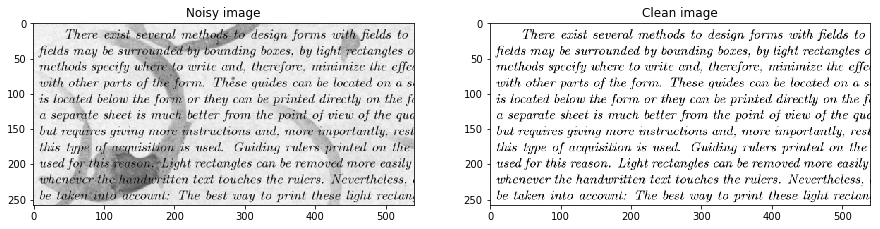

In [72]:
img_noisy = cv2.imread('./SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+train_images[0], cv2.IMREAD_GRAYSCALE)
img_clean = cv2.imread('./SimulatedNoisyOffice/clean_images_grayscale/'+train_targets[0], cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.imshow(img_noisy, cmap='gray')
plt.title("Noisy image")

plt.subplot(122)
plt.imshow(img_clean, cmap='gray')
plt.title("Clean image")
plt.show()

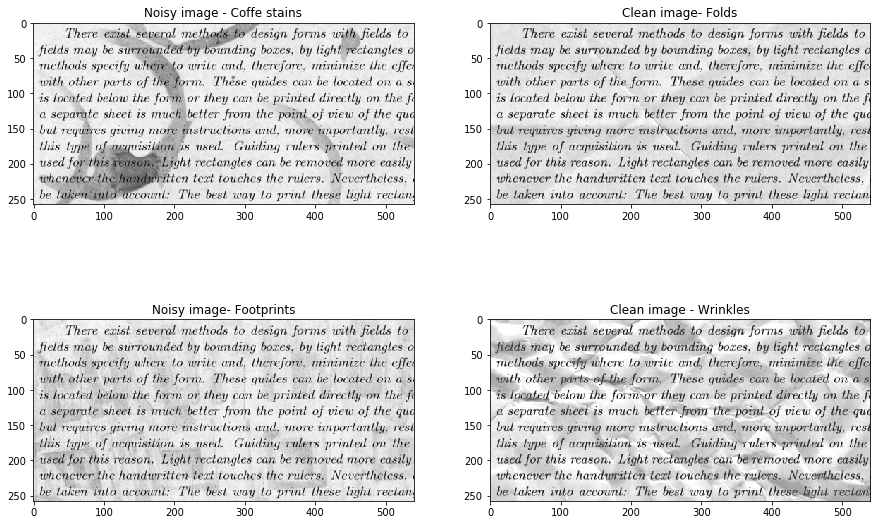

In [75]:
img_noisy_1 = cv2.imread('./SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+train_images[0], cv2.IMREAD_GRAYSCALE)
img_noisy_2 = cv2.imread('./SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+train_images[1], cv2.IMREAD_GRAYSCALE)
img_noisy_3 = cv2.imread('./SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+train_images[2], cv2.IMREAD_GRAYSCALE)
img_noisy_4 = cv2.imread('./SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+train_images[3], cv2.IMREAD_GRAYSCALE)


fig = plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(img_noisy_1, cmap='gray')
plt.title("Noisy image - Coffe stains")

plt.subplot(222)
plt.imshow(img_noisy_2, cmap='gray')
plt.title("Clean image- Folds")

plt.subplot(223)
plt.imshow(img_noisy_3, cmap='gray')
plt.title("Noisy image- Footprints")

plt.subplot(224)
plt.imshow(img_noisy_4, cmap='gray')
plt.title("Clean image - Wrinkles")
plt.show()

### Preparing data for model building

##### In order to use an Autoencoder the data needs to be prepared such that the model can access the noisy image and corresponding clean image during training and testing.

##### As we are using Pytorch to build the Denoising Autoencoder we need the data to be in Tensors. The following function reads the noisy and corresponding clean image, resizes all the images to be of same size and returns tensors containing noisy images and clean images.

In [76]:
def get_tensors(images_list, target_list):
    image_tensors = []
    target_tensors = []
    reference_target_list = [filename.split('_')[0] for filename in target_list]
    for filename in images_list:
        image = filename.split('_')[0]
        if image in reference_target_list:
            idx = reference_target_list.index(image)
            image = cv2.imread('./SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+filename, cv2.IMREAD_GRAYSCALE)
            target = cv2.imread('./SimulatedNoisyOffice/clean_images_grayscale/'+target_list[idx], cv2.IMREAD_GRAYSCALE)
            
            image = cv2.resize(image, (540, 420), interpolation = cv2.INTER_AREA)
            target = cv2.resize(target, (540, 420), interpolation = cv2.INTER_AREA)

            image = torch.from_numpy(image/255).unsqueeze(0)
            target = torch.from_numpy(target/255).unsqueeze(0)
            image_tensors.append(image)
            target_tensors.append(target)

    image_tensors = torch.stack(image_tensors)
    target_tensors = torch.stack(target_tensors)
    return image_tensors, target_tensors

##### Loading data into tensors

In [ ]:
train_data, train_targets = get_tensors(train_images, train_targets)
valid_data, valid_targets = get_tensors(valid_images, valid_targets)
test_data, test_targets = get_tensors(test_images, test_targets)

##### Defining a Dataset class in order to efficiently use the Dataloader from Pytorch

In [16]:
class NoisyImagesDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

##### Writing training and evaluation functions

In [18]:
def execute_trainstep(model, device, loader, loss_criterion, optimizer):
    model.train()
    losses = []
    for idx, (noisy, clean) in enumerate(loader):
        
        noisy = noisy.to(device)
        clean = clean.to(device)
        
        optimizer.zero_grad()
        
        out = model(noisy)
        loss = loss_criterion(out, clean)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
    return np.mean(losses)

def validate(model, device, loader, loss_criterion):
    model.eval()
    losses = []
    for idx, (noisy, clean) in enumerate(loader):
        
        noisy = noisy.to(device)
        clean = clean.to(device)
        
        out = model(noisy)
        
        loss = loss_criterion(out, clean)
        losses.append(loss.item())
    
    return np.mean(losses) 

### Denoising Autoencoder

##### The autoencoder consistes of two parts, an encoder and a decoder. The Encoder compresses the image into lower dimensions capturing the details and the Decoder builds the image from this compressed representation.

##### Training the auto encoder by giving noisy images as input and clean images as a reference to learn from. The Encoder will compress the image and the Decoder will decode the compressed representation in such a way that it cleans the image.


In [77]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 12, 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 24, 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 48, 1),
            nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(24, 12, 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(12, 6, 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(6, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
torch.cuda.empty_cache()

#### Defining Hyperparameters for training and preparing Dataloaders

#### Mean Squared Error is used here for calculating how far the noisy image is from the clean image. In a way this represents the amount of noise present in the image. 

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 0.001
epochs = 30
batch_size = 2

train_dataset = NoisyImagesDataset(train_data, train_targets)
valid_dataset = NoisyImagesDataset(valid_data, valid_targets)
test_dataset = NoisyImagesDataset(test_data, test_targets)

train_loader = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.dataloader.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.dataloader.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


model = DenoisingAutoEncoder().to(device).double()
loss_criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

## Training and Validation

#### The model parameters are updated based on the error obtained on the training data. A validation set is used to evaluate the performance of the model on unseen data. 

In [22]:
train_losses = []
valid_losses = []

for epoch in range(1, epochs+1):
    train_losses.append(execute_trainstep(model, device, train_loader, loss_criterion, optimizer))
    valid_losses.append(validate(model, device, valid_loader, loss_criterion))
    
    print(f"Epoch {epoch}/{epochs} Training Loss : {train_losses[-1]:.6f} Validation Loss : {valid_losses[-1]:.6f}")

Epoch 1/30 Training Loss : 0.182730 Validation Loss : 0.084731
Epoch 2/30 Training Loss : 0.069378 Validation Loss : 0.065491
Epoch 3/30 Training Loss : 0.058831 Validation Loss : 0.045250
Epoch 4/30 Training Loss : 0.030708 Validation Loss : 0.026208
Epoch 5/30 Training Loss : 0.019264 Validation Loss : 0.018298
Epoch 6/30 Training Loss : 0.014272 Validation Loss : 0.018833
Epoch 7/30 Training Loss : 0.012972 Validation Loss : 0.017353
Epoch 8/30 Training Loss : 0.012370 Validation Loss : 0.016091
Epoch 9/30 Training Loss : 0.011726 Validation Loss : 0.014754
Epoch 10/30 Training Loss : 0.010014 Validation Loss : 0.013375
Epoch 11/30 Training Loss : 0.008788 Validation Loss : 0.013598
Epoch 12/30 Training Loss : 0.007837 Validation Loss : 0.011125
Epoch 13/30 Training Loss : 0.007150 Validation Loss : 0.009571
Epoch 14/30 Training Loss : 0.005882 Validation Loss : 0.008227
Epoch 15/30 Training Loss : 0.005027 Validation Loss : 0.007520
Epoch 16/30 Training Loss : 0.004459 Validation L

##### Plotting the Training and Validation errors

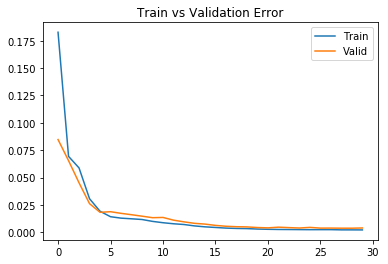

In [78]:
plt.plot(train_losses, label ='Train')
plt.plot(valid_losses, label ='Valid')
plt.title("Train vs Validation Error")
plt.legend()
plt.show()

## Testing

#### Now that the model is trained and validated, we can test it on Test data. Usually this test data is never seen by the model and will give us a better understanding on how well the model will perform in the real world when it is deployed.

In [80]:
# We can use the same validation function we wrote earlier for Testing
test_error = validate(model, device, test_loader, loss_criterion)
print(f"Test Error : {test_error:.6f}")

Test Error : 0.004073


#### The test error is close to the validation and training errors which we obtained above, So we can say that the model is performing similarly on the testing data as it has on training and validation data.

### Now let us see whether it actually removes any noise from the images

In [94]:
def denoise(test_data, i, denoise):
    out = model(test_data[i].unsqueeze_(0).to(device))
    out = out.detach().squeeze(0).squeeze(0).cpu().numpy()
    
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.imshow(test_data[i].squeeze(0).numpy(), cmap='gray')
    plt.title("Noisy image")

    plt.subplot(122)
    plt.imshow(out, cmap='gray')
    plt.title("Cleaned image")
    plt.show()

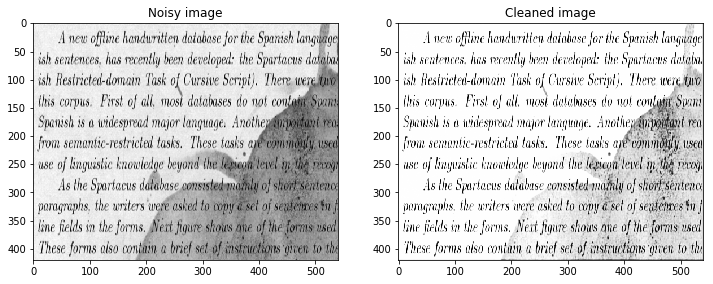

In [95]:
denoise(test_data, 0, device)

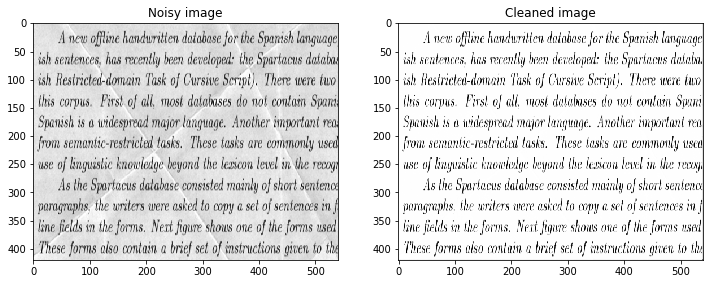

In [96]:
denoise(test_data, 1, device)

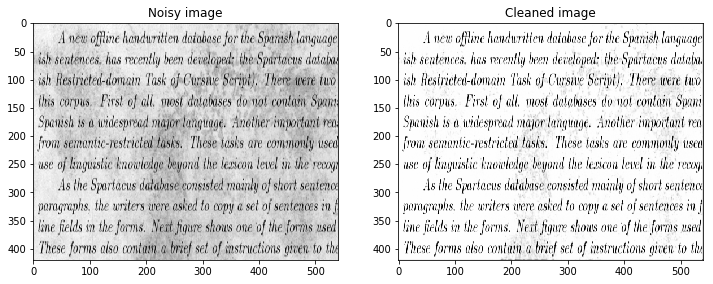

In [97]:
denoise(test_data, 2, device)

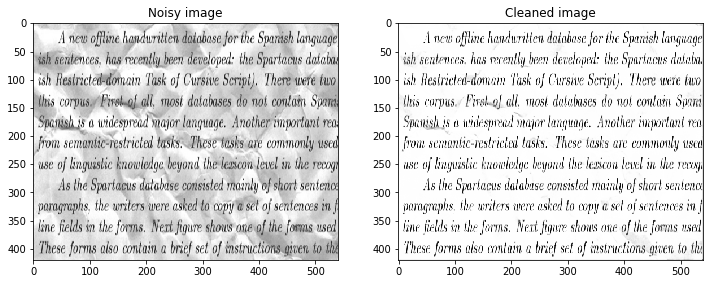

In [99]:
denoise(test_data, 3, device)

### As seen, the model removes wrinkles and folds from the noisy images and still struggles to remove coffee stains and footprints. The performance can be still improved by choosing a bigger network and tuning the hyperparameters.